<a href="https://colab.research.google.com/github/DmytroTym/urban/blob/master/Elections_digitalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Діджиталізація результатів виборів

## Постановка задачі

Це пост про місцеві вибори в Києві, які [пройшли](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D1%81%D1%86%D0%B5%D0%B2%D1%96_%D0%B2%D0%B8%D0%B1%D0%BE%D1%80%D0%B8_%D0%B2_%D0%9A%D0%B8%D1%94%D0%B2%D1%96_2020) в один тур 25 жовтня 2020 року. Я пишу цей пост в кінці січня 2021, але краще пізно, ніж ніколи. Офіційні результати виборів можна знайти на [сайті ЦВК](https://www.cvk.gov.ua/pls/vm2020/pvm057pid112=30pid102=2pf7691=2pt001f01=695rej=0pt00_t001f01=695.html). Проблема в тому, що в кращому разі можна знайти [результати](https://kmr.gov.ua/uk/content/postanova-no-protokol-pro-rezultaty-vyboriv) по округах (які в основному співпадають з районами міста). Це унеможливлює серйозний аналіз і пошук аномалій зокрема; для цього потрібні результати по окремим дільницям (на дільниці зазвичай зареєстровані декілька тисяч виборців).

На щастя, команда народного депутата Романа Грищука [виклала](https://www.facebook.com/romagrishchuk/posts/1498622463655302) на [гугл-диск](http://bit.ly/SolomaVote) заповнені бланки з результатами на всіх дільницях Солом'янського району. Щоправда, це скани пдф-ок з заповненими від руки кількостями голосів. Оцифровкою цих бланків я й займуся в даному ноутбуці. Посилання на аналіз результатів з'явиться тут щойно я його закінчу.

### Приклад бланків

Тут будуть приклади бланків. Поки ви можете знайти їх на [гугл-диску](http://bit.ly/SolomaVote) Романа Грищука

## Машинне навчання для розпізнавання рукописних чисел

Десь в стіні коду, яку я поки не упорядкував, можна знайти модель, навчану розпізнавати рукописні числа від 0 до 999. Це ResNet-18, до якої замість останніх шарів: пулінгу по висоті і ширині та лінійного шару, прикручний пулінг лише по висоті та ctc-loss по ширині. Я впорядкую релевантний код та краще поясню ідею пізніше. Дані, які я використовую на тренуванні --- mnist та синтетичні двох- та трьохцифрові числа, утворені конкатенацією цифр з mnist'а. Одноцифрових чисел в датасеті найбільше, що відображає реальність розподілу чисел в бланках. Точність розпізнвання на тесті досягає $99.2\%$. Я не очікую такої самої точності на реальних даних з ряду причин, але "доучування" мережі буде здійснюватись по ходу виправлення помилок. На щастя, їх можна буде виправляти без перегляду всіх класифікацій мережі завдяки тому, що в бланках є "зайва" інформація, яка слугуватиме для мене чексумами.

## Отримання клітинок з бланків

Перед тим, як розпізавати числа, потрібно виділити їх з бланків. Аналогічно до попереднього пункту, ця робота вже зроблена (значною мірою базуючись на [цьому пості на towardsdatascience](https://towardsdatascience.com/a-table-detection-cell-recognition-and-text-extraction-algorithm-to-convert-tables-to-excel-files-902edcf289ec)) і протестована, але ще не причепурена. Бланки подекуди сфотографовані, подекуди зіскановані, якість може бути дуже різною, але все ж завдяки однаковому шаблону і табличній структурі, бланки виходить оцифрувати досить добре. 

## Власне оцифровка

Єдина ще не зроблена частина. Оцифровка з перевіркою чексум, ручним виправленням помилок і паралельним доучуванням мережі має відбутись найбличим часом. Результати будуть викладені у відкритий доступ.

Далі йде хаотичний код:

In [ ]:
!pip install pdf2image

In [ ]:
import cv2
import numpy as np
import os
import json
import imutils
import matplotlib.pyplot as plt
from pdf2image import convert_from_path, pdfinfo_from_path
plt.rcParams['figure.dpi'] = 200

In [ ]:
# приведення всіх зображень до однієї висоти в 2500 пікселів
def scale_img(page_as_image):
    height = 2500
    width = int(page_as_image.shape[1] * (height / page_as_image.shape[0]))
    dim = (width, height)
    return cv2.resize(page_as_image, dim, interpolation = cv2.INTER_AREA)

low_threshold = 150
high_threshold = 255

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments

def rotate_image(page_as_image):
    edges = cv2.Canny(page_as_image, low_threshold, high_threshold)

    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
        
    angles = np.degrees([np.arctan((line[0][0]-line[0][2])/(line[0][1]-line[0][3]))
                        for line in lines])
    angles = [angle for angle in angles if abs(angle) < 45]
    if len(angles) > 0:
        page_as_image = imutils.rotate(page_as_image, -np.median(angles))
        page_as_image[:40,:] = 255
        page_as_image[-40:,:] = 255
        page_as_image[:,:40] = 255
        page_as_image[:,-40:] = 255

    return page_as_image

In [ ]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def get_table(page_as_image, mode="binary_thresh"):
    img_bin = cv2.bitwise_not(page_as_image)
    # plt.imshow(page_as_image, cmap='gray')
    # plt.show()

    # Length(width) of kernel as 100th of total width
    kernel_len = np.array(page_as_image).shape[1]//100
    # Defining a vertical kernel to detect all vertical lines of image 
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
    vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

    #Use horizontal kernel to detect the horizontal lines
    image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

    img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    #Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)
    # plt.imshow(img_vh, cmap='gray')
    # plt.show()
    if mode == "binary_thresh":
      thresh, img_vh = cv2.threshold(img_vh, 225, 255, cv2.THRESH_BINARY)
    else:
      img_vh = cv2.adaptiveThreshold(img_vh, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 11, 5)
    # plt.imshow(img_vh, cmap='gray')
    # plt.show()

    table_edges = cv2.Canny(img_vh, 50, high_threshold)
    table_lines = cv2.HoughLinesP(table_edges, rho, theta, 3, np.array([]),
                                  min_line_length, 50)
    for line in table_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img_vh,(x1,y1),(x2,y2),0,2)

    # Detect contours for following box detection
    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort all the contours by top to bottom.
    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

    #Creating a list of heights for all detected boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
    #Get mean of heights
    mean = np.mean(heights)

    #Create list box to store all boxes in  
    boxes = []
    # Get position (x,y), width and height for every contour and show the contour on image
    for c in contours:
        xs, ys = [c_[0][0] for c_ in c], [c_[0][1] for c_ in c]
        if max(xs) - min(xs) > 10 and max(ys) - min(ys) > 10:
            x, y, w, h = cv2.boundingRect(c)
            if h < 200:
                boxes.append([x,y,w,h])
          
    return boxes

In [ ]:
def reconstruct_table(boxes):               
  def find_boxes(x, y, w, h, corner, tolerance = 10):
    res_list = []
    for box in boxes:
      if (w is None or abs(w - box[2]) < tolerance) and (h is None or abs(h - box[3]) < tolerance):
        if corner == 'top-left':
          if abs(x - box[0]) < tolerance and abs(y - box[1]) < tolerance:
            res_list.append(box)
        if corner == 'top-right':
          if abs(x - box[0] - box[2]) < tolerance and abs(y - box[1]) < tolerance:
            res_list.append(box)
        if corner == 'bottom-left':
          if abs(x - box[0]) < tolerance and abs(y - box[1] - box[3]) < tolerance:
            res_list.append(box)
        if corner == 'bottom-right':
          if abs(x - box[0] - box[2]) < tolerance and abs(y - box[1] - box[3]) < tolerance:
            res_list.append(box)
    return res_list

  appended_boxes = 0
  while True:
    all_boxes_added = True
    for box1 in boxes:
      for box2 in find_boxes(box1[0], box1[1], None, box1[3], corner='top-right'):
        for box3 in find_boxes(box1[0], box1[1] + box1[3], box1[2], None, corner='top-left'):
          if len(find_boxes(box1[0], box3[1], box2[2], box3[3], corner='top-right')) == 0:
            boxes.append([box2[0], box3[1], box2[2], box3[3]])
            appended_boxes += 1
            if appended_boxes > 1000:
              return
            all_boxes_added = False
        for box3 in find_boxes(box1[0], box1[1], box1[2], None, corner='bottom-left'):
          if len(find_boxes(box1[0], box1[1], box2[2], box3[3], corner='bottom-right')) == 0:
            boxes.append([box2[0], box3[1], box2[2], box3[3]])
            appended_boxes += 1
            if appended_boxes > 1000:
              return
            all_boxes_added = False
      for box2 in find_boxes(box1[0] + box1[2], box1[1], None, box1[3], corner='top-left'):
        for box3 in find_boxes(box1[0], box1[1] + box1[3], box1[2], None, corner='top-left'):
          if len(find_boxes(box2[0], box3[1], box2[2], box3[3], corner='top-left')) == 0:
            boxes.append([box2[0], box3[1], box2[2], box3[3]])
            appended_boxes += 1
            if appended_boxes > 1000:
              return
            all_boxes_added = False
        for box3 in find_boxes(box1[0], box1[1], box1[2], None, corner='bottom-left'):
          if len(find_boxes(box2[0], box3[1] + box3[3], box2[2], box3[3], corner='bottom-left')) == 0:
            boxes.append([box2[0], box3[1], box2[2], box3[3]])
            appended_boxes += 1
            if appended_boxes > 1000:
              return
            all_boxes_added = False
    if all_boxes_added:
      return

def process_image(page_as_image, cell_widths, cell_ratios):
  page_as_image = rotate_image(scale_img(page_as_image))
  boxes = get_table(page_as_image) + get_table(page_as_image, mode='other')
  reconstruct_table(boxes)
  boxes.sort(key=lambda x: x[1])
  added_boxes = []

  def is_box_not_added(b):
    for other_box in added_boxes:
      if other_box[1] < b[1] + 15 and other_box[1] + other_box[3] > b[1] + b[3] - 15:
        return False
    return True

  def get_good_boxes():
    image = None
    img = np.ones(page_as_image.shape) * 255
    for b in boxes:
      # print(b)
      for cell_width, cell_ratio in zip(cell_widths, cell_ratios):
        if abs(b[2] - cell_width) < 30 and is_box_not_added(b) and \
        (cell_ratio is None or abs(b[2] / b[3] - cell_ratio) < 0.4):
          image = cv2.rectangle(img,(b[0],b[1]),(b[0]+b[2],b[1]+b[3]),0,6)
          added_boxes.append(b)
          yield page_as_image[b[1] + 2:b[1] + b[3] - 2, b[0] + 2:b[0] + b[2] - 2]
        else:
          image = cv2.rectangle(img,(b[0],b[1]),(b[0]+b[2],b[1]+b[3]),0,2)
    # plt.imshow(image)
    # plt.show()

  good_boxes = list(get_good_boxes())
  med = np.median([gb[0] for gb in added_boxes])
  return [gb for i, gb in enumerate(good_boxes) if abs(added_boxes[i][0] - med) < 15]

In [ ]:
def split_by_local_minima(x_coord_list):
    if len(x_coord_list) < 50:
        return []
    for i in reversed(range(min(x_coord_list) + 4, max(x_coord_list) - 4)):
        if all([len([1 for x in x_coord_list if x == i - j]) < 10 for j in range(-1, 2)]):
            return split_by_local_minima([x for x in x_coord_list if x < i]) + \
        split_by_local_minima([x for x in x_coord_list if x > i])
    return [x_coord_list]

def resize_28_28(img_to_resize):
    if img_to_resize.shape[0] > img_to_resize.shape[1]:
        diff = img_to_resize.shape[0] - img_to_resize.shape[1]
        square_image = np.hstack((255 * np.ones((img_to_resize.shape[0], diff // 2)), img_to_resize,
                                 255 * np.ones((img_to_resize.shape[0], diff // 2 + diff % 2))))
        return cv2.resize(square_image, (28, 28), interpolation = cv2.INTER_AREA)
    else:
        diff = img_to_resize.shape[1] - img_to_resize.shape[0]
        square_image = np.vstack((255 * np.ones((diff // 2, img_to_resize.shape[1])), img_to_resize,
                                 255 * np.ones((diff // 2 + diff % 2, img_to_resize.shape[1]))))
        return cv2.resize(square_image, (28, 28), interpolation = cv2.INTER_AREA)

def digits_segmentation(digits_img):
    plt.imshow(digits_img, cmap = 'gray')
    plt.show()
    cY, cX = digits_img.shape[:2]
    digits_img = cv2.fastNlMeansDenoising(digits_img, h=15, templateWindowSize=7, searchWindowSize=21)
    best_angle, num_of_digits, num_of_pixels, cumulative_dist = 0, 0, 0, 0 

    for rotation_angle in range(-20, 21, 5):
        M = cv2.getRotationMatrix2D((cX // 2, cY // 2), rotation_angle, 1.0)
        rotated_img = cv2.warpAffine(digits_img, M, (cX, int(cY * 1.5)), borderValue=(255,255,255))
        black_pixels_x_coords = np.where(rotated_img < 250)[1]
        clusters = [(min(l), max(l)) for l in split_by_local_minima(black_pixels_x_coords)]

        if (len(clusters) > num_of_digits and len(clusters) < 5):
            number_of_digits = len(clusters)
            best_angle = (rotation_angle, list(clusters))
            cumulative_dist = sum([clusters[i + 1][0] - cluster[1] for i, cluster in enumerate(clusters[:-1])])
            num_of_pixels = len([1 for x in black_pixels_x_coords if x >= clusters[0][0] and x <= clusters[-1][1]])
        elif (len(clusters) == num_of_digits):
            cum_dist = sum([clusters[i + 1][0] - cluster[1] for i, cluser in enumerate(clusters[:-1])])
            num_of_pix = len([1 for x in black_pixels_x_coords if x >= clusters[0][0] and x <= clusters[-1][1]])
            if num_of_digits > 1 and cum_dist > cumulative_dist:
                best_angle = (rotation_angle, list(clusters))
                cumulative_dist = cum_dist
            if num_of_digits == 1 and num_of_pixels < num_of_pix:
                best_angle = (rotation_angle, list(clusters))
                num_of_pixels = num_of_pix

    M = cv2.getRotationMatrix2D((cX // 2, cY // 2), best_angle[0], 1.0)
    rotated_img = cv2.warpAffine(digits_img, M, (cX, int(cY * 1.5)), borderValue=(255,255,255))

    for limits in best_angle[1]:
        y_coords = np.where(rotated_img[:, limits[0]:limits[1]] < 200)[0]
        if len(y_coords) > 0 and limits[1] - limits[0] > 2:
            rotated_one_digit = rotated_img[min(y_coords) - 4:max(y_coords) + 4, limits[0]:limits[1]]
            d = rotated_one_digit.shape[1] // 5
            rotated_one_digit = np.hstack((255 * np.ones((rotated_one_digit.shape[0], d)), rotated_one_digit,
                                          255 * np.ones((rotated_one_digit.shape[0], d))))
            M_inv = cv2.getRotationMatrix2D((rotated_one_digit.shape[1] // 2, rotated_one_digit.shape[0] // 2),
                                            -best_angle[0], 1.0)
            try:
                one_digit = cv2.warpAffine(rotated_one_digit, M_inv,
                                          (rotated_one_digit.shape[1], rotated_one_digit.shape[0]),
                                          borderValue=(255,255,255))
                _, one_digit_binary = cv2.threshold(resize_28_28(one_digit),230,255,cv2.THRESH_BINARY_INV)
                # plt.imshow(one_digit_binary, 'gray')
                # plt.show()
                # print('Label is', get_label(one_digit_binary))
                yield one_digit_binary
            except:
                print('Error, shape:', rotated_one_digit.shape)

In [ ]:
!wget https://www.cntk.ai/OnnxModels/mnist/opset_7/mnist.tar.gz

!tar -xzf mnist.tar.gz

--2020-12-06 13:44:47--  https://www.cntk.ai/OnnxModels/mnist/opset_7/mnist.tar.gz
Resolving www.cntk.ai (www.cntk.ai)... 137.117.9.212
Connecting to www.cntk.ai (www.cntk.ai)|137.117.9.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25959 (25K) [application/x-gzip]
Saving to: ‘mnist.tar.gz’

mnist.tar.gz        100%[===================>]  25.35K  --.-KB/s    in 0.05s   

2020-12-06 13:44:47 (502 KB/s) - ‘mnist.tar.gz’ saved [25959/25959]



In [ ]:
model_dir ="./mnist"
model=model_dir+"/model.onnx"
session = onnxruntime.InferenceSession(model, None)

In [ ]:
!pip install easyocr Pillow

     |████████████████████████████████| 57.2MB 56kB/s 


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,779 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

In [ ]:
import easyocr
from PIL import Image
import pytesseract

def get_label(digit_img):
  digit_img.resize((1, 1, 28, 28))

  data = json.dumps({'data': digit_img.tolist()})
  data = np.array(json.loads(data)['data']).astype('float32')
  input_name = session.get_inputs()[0].name
  output_name = session.get_outputs()[0].name
  result = session.run([output_name], {input_name: data})
  prediction = int(np.argmax(np.array(result).squeeze(), axis=0))
  return prediction

def predict(number_img, reader):
  if number_img is None:
    return None
  number_img = cv2.fastNlMeansDenoising(number_img, h=15, templateWindowSize=7, searchWindowSize=21)
  pil_image = Image.fromarray(number_img)
  # plt.imshow(np.asarray(pil_image), cmap='gray')
  plt.imshow(number_img, cmap='gray')
  plt.show()
  res = pytesseract.image_to_string(pil_image, config='--oem 0 tessedit_char_whitelist=0123456789')
  # res = reader.readtext(number_img, allowlist = '0123456789')
  print(res)
  try:
    res = res[0][1]
  except:
    return 0
  if len(res) > 0:
    return int(res)
  else:
    return 0
  # try:
  #   if number_img is None:
  #     return None
  #   digits = list(digits_segmentation(number_img))
  #   if len(digits) == 0:
  #     return 0
  #   return int(''.join(str(get_label(digit)) for digit in digits))
  # except Exception as e:
  #   print(e)
  #   return None

In [ ]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"

from google.colab import drive
drive.mount('/content/gdrive')

!cp -r "/content/gdrive/My Drive/Солома_Паралельний_підрахунок.zip" ./
!cp -r "/content/gdrive/My Drive/mnist_png.zip" ./

!unzip /content/Солома_Паралельний_підрахунок.zip
!unzip /content/mnist_png.zip

Streaming output truncated to the last 5000 lines.
  inflating: mnist_png/training/9/21639.png  
  inflating: mnist_png/training/9/21645.png  
  inflating: mnist_png/training/9/21646.png  
  inflating: mnist_png/training/9/21657.png  
  inflating: mnist_png/training/9/21669.png  
  inflating: mnist_png/training/9/21686.png  
  inflating: mnist_png/training/9/21718.png  
  inflating: mnist_png/training/9/21724.png  
  inflating: mnist_png/training/9/21748.png  
  inflating: mnist_png/training/9/21756.png  
  inflating: mnist_png/training/9/21757.png  
  inflating: mnist_png/training/9/21774.png  
  inflating: mnist_png/training/9/21786.png  
  inflating: mnist_png/training/9/21787.png  
  inflating: mnist_png/training/9/21807.png  
  inflating: mnist_png/training/9/21827.png  
  inflating: mnist_png/training/9/21835.png  
  inflating: mnist_png/training/9/21840.png  
  inflating: mnist_png/training/9/21842.png  
  inflating: mnist_png/training/9/21859.png  
  inflating: mnist_png/traini

In [44]:
import torch

In [45]:
import torchvision.models as models

In [46]:
resnet18 = models.resnet18(pretrained=True)
# for param in resnet18.parameters():
#     param.requires_grad = False

In [ ]:
from torchsummary import summary

summary(resnet18, (3, 224, 336), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 168]           9,408
       BatchNorm2d-2         [-1, 64, 112, 168]             128
              ReLU-3         [-1, 64, 112, 168]               0
         MaxPool2d-4           [-1, 64, 56, 84]               0
            Conv2d-5           [-1, 64, 56, 84]          36,864
       BatchNorm2d-6           [-1, 64, 56, 84]             128
              ReLU-7           [-1, 64, 56, 84]               0
            Conv2d-8           [-1, 64, 56, 84]          36,864
       BatchNorm2d-9           [-1, 64, 56, 84]             128
             ReLU-10           [-1, 64, 56, 84]               0
       BasicBlock-11           [-1, 64, 56, 84]               0
           Conv2d-12           [-1, 64, 56, 84]          36,864
      BatchNorm2d-13           [-1, 64, 56, 84]             128
             ReLU-14           [-1, 64,

In [47]:
import torch.nn as nn

class MyPooling(nn.Module):
    def __init__(self, *args):
        super(MyPooling, self).__init__()
        self.shape = args

    def forward(self, x):
        return torch.mean(x, dim=-2, keepdim=False)

class Transpose1(nn.Module):
    def __init__(self, *args):
        super(Transpose1, self).__init__()
        self.shape = args

    def forward(self, x):
        return torch.reshape(x, (-1, 512, 11)).permute(0, 2, 1)

class Transpose2(nn.Module):
    def __init__(self, *args):
        super(Transpose2, self).__init__()
        self.shape = args

    def forward(self, x):
        return torch.reshape(x, (-1, 11, 11)).permute(1, 0, 2)

resnet18.avgpool = MyPooling()
resnet18.fc = torch.nn.Sequential(Transpose1(),
                                  torch.nn.Linear(in_features=512, out_features=11),
                                  torch.nn.LogSoftmax(dim=-1),
                                  Transpose2())

# device = torch.cuda.set_device(0)

# resnet18.to(device)
# x = torch.randn(3, 3, 224, 336)
# output = resnet18(x)
# print(output.shape)

In [48]:
resnet18.cuda()
x = torch.randn(1, 3, 224, 336).cuda()
output = resnet18(x)
print(output.shape)

torch.Size([11, 1, 11])


In [ ]:
x = torch.randn(3, 3, 224, 336).cuda()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)

input_lengths = torch.full(size=(3,), fill_value=11, dtype=torch.long)
# target_lengths = torch.randint(low=2, high=2, size=(3,), dtype=torch.long)
target_lengths = torch.tensor([2, 2, 2])
target = torch.randint(low=1, high=10, size=(6,), dtype=torch.long)

ctc_loss = torch.nn.CTCLoss()
for j in range(5):
    res = resnet18(x)
    print(res.shape, target.shape, input_lengths.shape, target_lengths.shape)
    loss = ctc_loss(res, target, input_lengths, target_lengths)
    print(loss)
    print(check_correct(res, target, target_lengths))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.Size([11, 3, 11]) torch.Size([6]) torch.Size([3]) torch.Size([3])
tensor(7.9988, device='cuda:0', grad_fn=<MeanBackward0>)
0
torch.Size([11, 3, 11]) torch.Size([6]) torch.Size([3]) torch.Size([3])
tensor(8.4490, device='cuda:0', grad_fn=<MeanBackward0>)
0
torch.Size([11, 3, 11]) torch.Size([6]) torch.Size([3]) torch.Size([3])
tensor(13.1108, device='cuda:0', grad_fn=<MeanBackward0>)
0
torch.Size([11, 3, 11]) torch.Size([6]) torch.Size([3]) torch.Size([3])
tensor(14.1418, device='cuda:0', grad_fn=<MeanBackward0>)
0
torch.Size([11, 3, 11]) torch.Size([6]) torch.Size([3]) torch.Size([3])
tensor(11.9155, device='cuda:0', grad_fn=<MeanBackward0>)
0


In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
import time
import copy
import numpy as np

def check_correct(predictions, target, label_length):
    predictions = np.array([torch.max(predictions.cpu()[i, :, :], 1)[1].numpy()
                            for i in range(11)])
    corrects = 0
    for i in range(predictions.shape[1]):
        ith_predictions = predictions[:, i]
        ith_target = target[sum(label_length[:i]):sum(label_length[:i+1])]
        prev_pixel, normal_preds = 0, []
        for pixel_prediction in ith_predictions:
            if pixel_prediction != 0 and pixel_prediction != prev_pixel:
                normal_preds.append(pixel_prediction)
            prev_pixel = pixel_prediction
        if tuple(normal_preds) == tuple(ith_target):
            corrects += 1
    return corrects

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        last_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['training', 'testing']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for j, (inputs, labels) in enumerate(dataloaders[phase]):
                labels = [image_datasets[phase].classes[label]
                          for label in labels]
                inputs = inputs.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    # _, preds = torch.max(outputs, 1)
                    input_lengths = torch.full(size=(len(labels),),
                                               fill_value=11, dtype=torch.long)
                    target_lengths = torch.tensor([len(str(label)) \
                                                  for label in labels])
                    labels = torch.tensor([int(x) + 1 for label in labels
                                           for x in label])
                    # if j > 220 and j < 250:
                    #     for img_ in inputs:
                    #         imshow(img_.cpu())
                    #     outs = np.array([torch.max(outputs.cpu()[i, :, :], 1)[1].numpy()
                    #                      for i in range(11)])
                    #     print(phase, outs, labels, target_lengths)
                    loss = criterion(outputs, labels, input_lengths, target_lengths)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += check_correct(outputs, labels, target_lengths)
            if phase == 'training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Accuracy {:.4f} Time {:.0f} seconds'.format(
                phase, epoch_loss, epoch_acc, time.time() - last_time))

            # deep copy the model
            if phase == 'testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import transforms, datasets
import os

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'training': transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor()]),
    'testing': transforms.Compose([transforms.Resize(224),
                                   transforms.ToTensor()]),
}

data_dir = '/content/mnist_png'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) \
                  for x in ['training', 'testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) \
               for x in ['training', 'testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
train_class_names = image_datasets['training'].classes

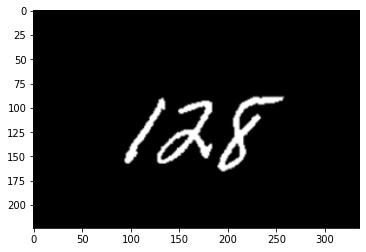

7 128


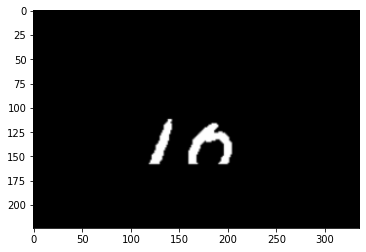

2 10


KeyboardInterrupt: ignored

In [ ]:
test_class_names = image_datasets['testing'].classes
for i, (inputs, labels) in enumerate(dataloaders['testing']):
  for input, label in zip(inputs, labels):
    inp = input.numpy().transpose((1, 2, 0))
    if label.numpy() < 10 and label.numpy() > 1:
      plt.imshow(inp)
      plt.show()
      print(label.numpy(), test_class_names[label.numpy()])

  # if i > 2:
  #   break

# visualize_model(resnet18)

In [ ]:
ctc_loss = torch.nn.CTCLoss(reduction='mean')

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(resnet18.parameters(), lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(resnet18, ctc_loss, optimizer_ft,
                       exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
training Loss: 0.3251 Accuracy 0.8782 Time 492 seconds
testing Loss: 0.0607 Accuracy 0.9717 Time 535 seconds
Epoch 1/24
----------
training Loss: 0.0575 Accuracy 0.9759 Time 492 seconds
testing Loss: 0.0423 Accuracy 0.9813 Time 536 seconds
Epoch 2/24
----------
training Loss: 0.0355 Accuracy 0.9851 Time 492 seconds
testing Loss: 0.0370 Accuracy 0.9838 Time 537 seconds
Epoch 3/24
----------
training Loss: 0.0246 Accuracy 0.9901 Time 493 seconds
testing Loss: 0.0399 Accuracy 0.9827 Time 537 seconds
Epoch 4/24
----------
training Loss: 0.0201 Accuracy 0.9918 Time 495 seconds
testing Loss: 0.0272 Accuracy 0.9897 Time 538 seconds
Epoch 5/24
----------
training Loss: 0.0136 Accuracy 0.9943 Time 492 seconds
testing Loss: 0.0413 Accuracy 0.9830 Time 535 seconds
Epoch 6/24
----------
training Loss: 0.0122 Accuracy 0.9952 Time 491 seconds
testing Loss: 0.0345 Accuracy 0.9850 Time 534 seconds
Epoch 7/24
----------
training Loss: 0.0043 Accuracy 0.9985 Time 491 seconds
testin

In [ ]:
print(model_ft)
path = "/content/gdrive/My Drive/colab_models" 
torch.save(model_ft.state_dict(), path)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
general_cells = {1: 8, 2: 3}
general_cell_width = 202
general_cell_ratio = 202 / 76
general_alternative_cell_width = 209
general_alternative_cell_ratio = 209 / 59
parties_cells = {2: 16, 3: 8}
parties_all_cells = {3: 15, 4: 9}
parties_cell_width = 333
parties_cell_ratios = []
parties_all_cell_ratios = []
candidates_cells = [{4: 5}, {4: 9, 5: 1}, {5: 10}, {5: 10}, {5: 9, 6: 2},
                    {6: 8}, {6: 5}, {6: 5}, {6: 6}, {7: 7}, {7: 8}, {7: 11}, 
                    {8: 11}, {8: 5}, {8: 6}, {8: 3, 9: 2}, {9: 9}, {9: 5}, {9: 9},
                    {10: 5}, {10: 5}, {10: 12}, {10: 3, 11: 9}, {11: 12}]
candidates_cell_width = 251
candidates_cell_ratio = 251 / 48

In [ ]:
!apt-get update
!apt-get install poppler-utils

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/mai

In [ ]:
!pip install pytesseract Pillow

  Created wheel for pytesseract: filename=pytesseract-0.3.6-py2.py3-none-any.whl size=13629 sha256=a454412cc5ab6b7c63ca73e51b851e8b1f7a83e708c7ff10f943b0f2db15bfa6
  Stored in directory: /root/.cache/pip/wheels/ee/71/72/b98430261d849ae631e283dfc7ccb456a3fb2ed2205714b63f
Successfully built pytesseract


800916-п.pdf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in int_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in int_scalars


Unable to locate: 1 instead of 3


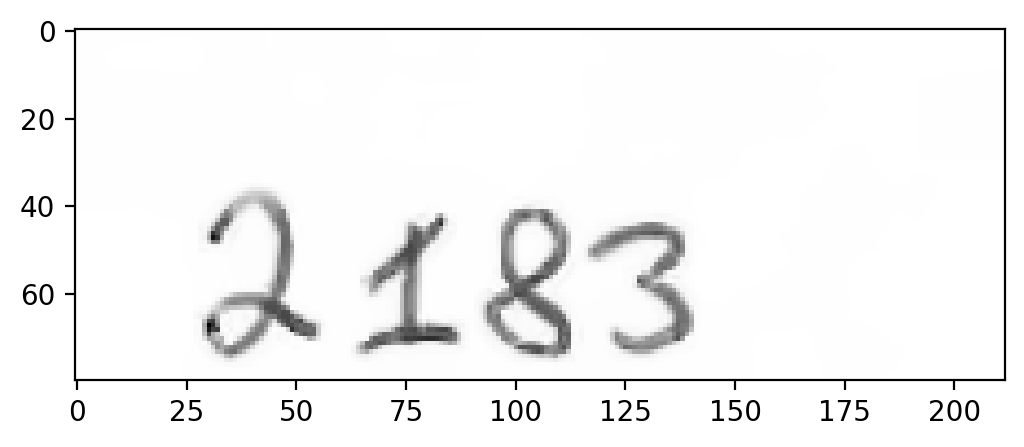

TesseractError: ignored

In [ ]:
def check_results(predicts, num_imgs):
    print(predicts)
    correct = set()
    if predicts[0] is not None:
        if predicts[1] is not None and predicts[6] is not None and \
        predicts[0] == predicts[1] + predicts[6]:
            correct.update([0, 1, 6])
            print('1 is correct', predicts[0], predicts[1], predicts[6])
            plt.imshow(num_imgs[0])
            plt.show()
            plt.imshow(num_imgs[1])
            plt.show()
            plt.imshow(num_imgs[6])
            plt.show()
        if predicts[4] is not None and predicts[5] is not None and predicts[6] is not None and \
        predicts[6] == predicts[5] + predicts[4]:
            correct.update([6, 4, 5])
            print('2 is correct', predicts[6], predicts[4], predicts[5])
            plt.imshow(num_imgs[6])
            plt.show()
            plt.imshow(num_imgs[4])
            plt.show()
            plt.imshow(num_imgs[5])
            plt.show()
    if predicts[8] is not None and predicts[9] is not None and predicts[10] is not None:
        if predicts[10] + predicts[9] == predicts[8]:
            correct.update([8, 9, 10])
            print('3 is correct', predicts[8], predicts[10], predicts[9])
            plt.imshow(num_imgs[8])
            plt.show()
            plt.imshow(num_imgs[9])
            plt.show()
            plt.imshow(num_imgs[10])
            plt.show()
    if predicts[8] is not None and predicts[6] is not None and predicts[7] is not None:
        if predicts[8] + predicts[7] == predicts[6]:
            correct.update([6, 8, 7])
            print('4 is correct', predicts[6], predicts[7], predicts[8])
            plt.imshow(num_imgs[6])
            plt.show()
            plt.imshow(num_imgs[7])
            plt.show()
            plt.imshow(num_imgs[8])
            plt.show()
    return len(correct)

reader = easyocr.Reader(['en'])
folder = '/content/Солома. Паралельний п_драхунок'
num_of_protocols, failed_pages, correct_numbers, all_numbers = 0, 0, 0, 0
i = 0
for filename in os.listdir(folder):
    i += 1
    if i > 100:
        break 
    # поки дивимось лише на голосування за партії, без кандидатів в мери
    if i > 2 and filename[-5] == "п":
        print(filename)
        num_of_protocols += 1
        path = os.path.join(folder, filename)
        # info = pdfinfo_from_path(path, userpw=None, poppler_path=None)
        # max_page = info["Pages"]
        number_boxes = {}
        # читаю по одній сторінці, інакше виникають проблеми з пам'яттю
        for page in general_cells:
            converted_page = convert_from_path(path, dpi=200, first_page=page, last_page=page)
            page_as_image = cv2.cvtColor(np.array(converted_page[0]), cv2.COLOR_BGR2GRAY)
            number_boxes[page] = process_image(page_as_image, [general_cell_width, general_alternative_cell_width],
                                               [general_cell_ratio, general_alternative_cell_ratio])
            # plt.imshow(page_as_image, cmap='gray')
            # plt.show()

        # for numbox in number_boxes.values():
        #     for nbx in numbox:
        #         plt.imshow(nbx, cmap='gray')
        #         plt.show()

        if sum([len(nboxes) for nboxes in number_boxes.values()]) == sum(general_cells.values()):
            to_predict = [number_box for number_boxs in number_boxes.values() 
            for number_box in number_boxs]
            predicted = [predict(number_box, reader) for number_box in to_predict]
            all_numbers += sum(general_cells.values())
            print('Located all!')
        else:
            to_predict = []
            for page, num_of_b in general_cells.items():
                if len(number_boxes[page]) == num_of_b:
                    to_predict.extend(number_boxes[page])
                    all_numbers += num_of_b
                else:
                    failed_pages += 1
                    to_predict.extend([None] * num_of_b)
                    print(f'Unable to locate: {len(number_boxes[page])} instead of {num_of_b}')
            predicted = [predict(number_box, reader) for number_box in to_predict]
        correct_numbers += check_results(predicted, to_predict)
print(failed_pages, 'failed pages from', num_of_protocols, 'protocols')
print(correct_numbers, 'correct numbers from', all_numbers, 'numbers')